# 787 Top 15 Longest Routes

This goal of this analysis is to identify the top 15 longest non-stop routes flown with the 787 since 2018-01-01.

In [1]:
# import libraries
from sign_on_configuration import adw
import pyodbc
import pandas as pd
import pickle
from geopy.distance import great_circle
import numpy as np
print("Pandas Version: {}".format(pd.__version__))

Pandas Version: 0.23.0


## Data Acquisition

In [56]:
# sql query
sql = '''
SELECT FL.AIRLINE_CODE AS OPER, 
		FL.TAIL_NO AS TAIL,
		FL.FLIGHT_NO AS FLIGHT, 
		FL.DEP_AIRPORT_CODE AS DEP,
		FL.ARR_AIRPORT_CODE AS ARR,
		FL.LEG_DATE AS LEG_DATE,
		DEP.AIRPORT_NAME AS DEP_AIRPORT, 
		DEP.CITY_NAME AS DEP_CITY,
		DEP.LATITUDE AS DEP_LAT,
		DEP.LONGITUDE AS DEP_LON,
		ARR.AIRPORT_NAME AS ARR_AIRPORT, 
		ARR.CITY_NAME AS ARR_CITY,
		ARR.LATITUDE AS ARR_LAT,
		ARR.LONGITUDE AS ARR_LON,
		FL.AIRPLANE_SUB_SERIES AS MINOR        
FROM ADW_VIEWS_ACM.ACM_FLIGHT_LEG AS FL
LEFT JOIN ADW_VIEWS_ACM.ACM_AIRPORT AS DEP
ON DEP = DEP.IATA_AIRPORT_CODE
LEFT JOIN ADW_VIEWS_ACM.ACM_AIRPORT AS ARR
ON ARR = ARR.IATA_AIRPORT_CODE
WHERE FL.MODEL = '787'
AND DEP <> ARR
AND LEG_DATE > '2018-01-01' (TIMESTAMP(0), FORMAT 'yyyy-mm-dd')
ORDER BY OPER, LEG_DATE;
'''

In [57]:
# query adw
with pyodbc.connect(f'DSN={adw.dsn}; UID={adw.uid}; PWD={adw.pwd}') as connection:
    og_df = pd.read_sql(sql, connection)

## Data Cleaning and Processing

In [59]:
# clean
df = (og_df.assign(FLIGHT=lambda x: pd.Categorical(x.FLIGHT),
                   OPER=lambda x: pd.Categorical(x.OPER),
                   TAIL=lambda x: pd.Categorical(x.TAIL),
                   DEP=lambda x: pd.Categorical(x.DEP),
                   ARR=lambda x: pd.Categorical(x.ARR),
                   DEP_AIRPORT=lambda x: pd.Categorical(x.DEP_AIRPORT),
                   DEP_CITY=lambda x: pd.Categorical(x.DEP_CITY),
                   ARR_AIRPORT=lambda x: pd.Categorical(x.ARR_AIRPORT),
                   ARR_CITY=lambda x: pd.Categorical(x.ARR_CITY),
                   MINOR=lambda x: pd.Categorical(x.MINOR),
                   CITY_PAIR=lambda x: list(zip(x.DEP,x.ARR)),
                   DEP_TUP=lambda x: list(zip(x.DEP_LAT,x.DEP_LON)),                     
                   ARR_TUP=lambda x: list(zip(x.ARR_LAT,x.ARR_LON))
                  )
      .dropna()
      .drop_duplicates(keep='first')
     )

# add number of times each flight was completed
df = df.merge((df[['OPER','CITY_PAIR']]
               .groupby('OPER')
               .CITY_PAIR
               .value_counts()
               .rename('NUM_FLIGHTS')
               .to_frame()
               .reset_index()),
              how='left',
              on=['OPER','CITY_PAIR']
             ).set_index('LEG_DATE')

# drop delivery flights
df = df.drop(df[(df.ARR_LAT == 0) | (df.ARR_LON == 0) | 
                (df.DEP_LAT == 0) | (df.DEP_LON == 0)].index)
df = df.drop(df[(df.DEP_CITY == 'Everett')].index)

# add calculated column for great circle distance
df['GCD_nm'] = (df.apply(
    lambda x:great_circle(x.DEP_TUP,x.ARR_TUP).miles,axis=1))

In [61]:
# save
with open('data/df_787routes.pickle','wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# load
with open('data/df_787routes.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [62]:
# stats
print(df.shape)
print(df.info())
display(df.head())

(309774, 19)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309774 entries, 2018-01-01 08:33:00 to 2018-09-10 14:26:00
Data columns (total 19 columns):
OPER           309774 non-null category
TAIL           309774 non-null category
FLIGHT         309774 non-null category
DEP            309774 non-null category
ARR            309774 non-null category
DEP_AIRPORT    309774 non-null category
DEP_CITY       309774 non-null category
DEP_LAT        309774 non-null float64
DEP_LON        309774 non-null float64
ARR_AIRPORT    309774 non-null category
ARR_CITY       309774 non-null category
ARR_LAT        309774 non-null float64
ARR_LON        309774 non-null float64
MINOR          309774 non-null category
CITY_PAIR      309774 non-null object
DEP_TUP        309774 non-null object
ARR_TUP        309774 non-null object
NUM_FLIGHTS    309774 non-null int64
GCD_nm         309774 non-null float64
dtypes: category(10), float64(5), int64(1), object(3)
memory usage: 29.5+ MB
None


,OPER,TAIL,FLIGHT,DEP,ARR,DEP_AIRPORT,DEP_CITY,DEP_LAT,DEP_LON,ARR_AIRPORT,ARR_CITY,ARR_LAT,ARR_LON,MINOR,CITY_PAIR,DEP_TUP,ARR_TUP,NUM_FLIGHTS,GCD_nm
LEG_DATE,,,,,,,,,,,,,,,,,,,
2018-01-01 08:33:00,AAL,N814AA,AA87,LHR,ORD,HEATHROW,London,51.4775,-0.461389,CHICAGO-O'HARE INTL,Chicago,41.9796,-87.9042,8,"(LHR, ORD)","(51.4775, -0.461389)","(41.9796, -87.9042)",866,3941.559333
2018-01-01 08:36:00,AAL,N814AA,AA87,ORD,PEK,CHICAGO-O'HARE INTL,Chicago,41.9796,-87.904200,BEIJING CAPITAL,Beijing,40.0750,116.5900,8,"(ORD, PEK)","(41.9796, -87.9042)","(40.075, 116.59)",237,6563.398220
2018-01-01 09:08:00,AAL,N819AN,AA154,NRT,ORD,NEW TOKYO INTL (NARITA),Tokyo,35.7669,140.388000,CHICAGO-O'HARE INTL,Chicago,41.9796,-87.9042,8,"(NRT, ORD)","(35.7669, 140.388)","(41.9796, -87.9042)",243,6259.467335
2018-01-01 09:13:00,AAL,N809AA,AA288,PVG,ORD,PUDONG,Shanghai,31.1417,121.790000,CHICAGO-O'HARE INTL,Chicago,41.9796,-87.9042,8,"(PVG, ORD)","(31.1417, 121.79)","(41.9796, -87.9042)",238,7043.008289
2018-01-01 09:38:00,AAL,N822AN,AA37,MAD,DFW,BARAJAS,Madrid,40.4722,-3.560940,DALLAS-FT WORTH INTL,Dallas/Fort Worth,32.8960,-97.0372,9,"(MAD, DFW)","(40.4722, -3.56094)","(32.896, -97.0372)",74,4954.822492


## Outputs

### Finding Top 15

Top 15 longest flights with no minimum.

In [176]:
# find top 15, option to set minimum number of flights
top15_df = (df[['OPER','TAIL','FLIGHT','CITY_PAIR','GCD_nm','NUM_FLIGHTS',
                'DEP_AIRPORT','DEP_CITY','ARR_AIRPORT','ARR_CITY']]
            .sort_values('GCD_nm',ascending=False)
            .drop_duplicates('CITY_PAIR')
            .drop_duplicates('GCD_nm')
#            .loc[lambda x: x.NUM_FLIGHTS > 2]   # min flights
            .head(15))
display(top15_df)

,OPER,TAIL,FLIGHT,CITY_PAIR,GCD_nm,NUM_FLIGHTS,DEP_AIRPORT,DEP_CITY,ARR_AIRPORT,ARR_CITY
LEG_DATE,,,,,,,,,,
2018-04-24 19:56:00,ETH,ETARE,ET672,"(GRU, HKG)",11186.839651,2,GUARULHOS INTL.,Sao Paulo,HONG KONG INTL,Hong Kong
2018-09-07 17:26:00,ETH,ETAOP,ET616,"(GRU, CAN)",11152.185222,1,GUARULHOS INTL.,Sao Paulo,BAIYUN,Guangzhou
2018-07-30 10:35:00,BEJ,B7879,CA908,"(GRU, PEK)",10921.949126,1,GUARULHOS INTL.,Sao Paulo,BEIJING CAPITAL,Beijing
2018-03-01 07:19:00,ETH,ETAOV,ET506,"(CTU, GRU)",10556.410845,1,SHUANGLIU,Chengdu,GUARULHOS INTL.,Sao Paulo
2018-05-05 11:02:00,QAN,VHZNB,QF9,"(MEL, LHR)",10506.532550,1,MELBOURNE INTL,Melbourne,HEATHROW,London
2018-02-12 13:10:00,BRI,GTUIA,BY746,"(CUN, HKT)",10392.207865,1,CANCUN INTL,Cancun,PHUKET INTL,Phuket
2018-02-10 10:01:00,AIN,VTANJ,AI302,"(FRA, SYD)",10250.455454,1,FRANKFURT/MAIN,Frankfurt,KINGSFORD SMITH INTL,Sydney
2018-01-14 11:02:00,BRI,GTUIA,BY690,"(CUN, PQC)",10154.858601,1,CANCUN INTL,Cancun,DUONGDONG,Phuquoc
2018-01-12 07:58:00,AIN,VTANY,AI308,"(FRA, MEL)",10135.981421,1,FRANKFURT/MAIN,Frankfurt,MELBOURNE INTL,Melbourne


If we set the minimum number of flights to 2, we see a substantial difference. This seems more representative of what you are trying to show.

In [177]:
# find top 15, option to set minimum number of flights
top15_df = (df[['OPER','TAIL','FLIGHT','CITY_PAIR','GCD_nm','NUM_FLIGHTS',
                'DEP_AIRPORT','DEP_CITY','ARR_AIRPORT','ARR_CITY']]
            .sort_values('GCD_nm',ascending=False)
            .drop_duplicates('CITY_PAIR')
            .drop_duplicates('GCD_nm')
            .loc[lambda x: x.NUM_FLIGHTS > 2]   # min flights
            .head(15))
display(top15_df)

,OPER,TAIL,FLIGHT,CITY_PAIR,GCD_nm,NUM_FLIGHTS,DEP_AIRPORT,DEP_CITY,ARR_AIRPORT,ARR_CITY
LEG_DATE,,,,,,,,,,
2018-07-20 12:22:00,QAN,VHZNC,QF10,"(LHR, PER)",9015.057101,170,HEATHROW,London,PERTH INTL,Perth
2018-01-24 02:48:00,UAL,N26966,UA38,"(SIN, LAX)",8762.083025,251,CHANGI,Singapore,LOS ANGELES INTL,Los Angeles
2018-05-12 03:30:00,UAL,N29961,UA101,"(IAH, SYD)",8597.186262,218,G BUSH INTERCONTINENTAL,Houston,KINGSFORD SMITH INTL,Sydney
2018-04-20 05:47:00,UAL,N24974,UA1,"(SFO, SIN)",8438.958453,250,SAN FRANCISCO INTL,San Francisco,CHANGI,Singapore
2018-08-11 23:48:00,ACN,CFRTU,AC38,"(MEL, YVR)",8202.342884,61,MELBOURNE INTL,Melbourne,VANCOUVER INTL,Vancouver
2018-07-19 05:35:00,AMX,N964AM,AM99,"(PVG, MEX)",8014.671184,160,PUDONG,Shanghai,LIC BENITO JUAREZ INTL,Mexico City
2018-02-24 06:39:00,UAL,N27959,UA98,"(LAX, MEL)",7927.400699,250,LOS ANGELES INTL,Los Angeles,MELBOURNE INTL,Melbourne
2018-09-02 11:59:00,QAN,VHZNC,QF49,"(MEL, SFO)",7862.571117,6,MELBOURNE INTL,Melbourne,SAN FRANCISCO INTL,San Francisco
2018-03-06 19:00:00,ACN,CFNOH,AC47,"(BOM, YYZ)",7763.040594,57,CHHATRAPATI SHIVAJI INTL,Mumbai,TORONTO/PEARSON INTL,Toronto


Version with coordinates for the map below.

In [178]:
# top 15 with coordinates
top15coord_df = (df[['OPER','TAIL','MINOR','GCD_nm','DEP_CITY','ARR_CITY','ARR_LAT',
               'ARR_LON','DEP_LAT','DEP_LON','CITY_PAIR','NUM_FLIGHTS']]
            .sort_values('GCD_nm',ascending=False)
            .drop_duplicates('CITY_PAIR')
            .drop_duplicates('GCD_nm')
            .loc[lambda x: x.NUM_FLIGHTS > 2]   # min flights
            .head(15))

In [995]:
# save
with open('data/df_787top15coords.pickle','wb') as handle:
    pickle.dump(top15coord_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# load
with open('data/df_787top15coords.pickle', 'rb') as handle:
    top15coord_df = pickle.load(handle)

### Text Summary

Text summary formatted in the same style as the powerpoint.

In [66]:
# subsetting and formatting data to print
p_out = top15_df[['DEP_CITY','ARR_CITY','GCD_nm','OPER']].values
cities = [city[0]+' - '+city[1] for city in p_out]

In [67]:
# formatted output
for i in range(len(p_out)):
    print('{:<30}'.format(cities[i]),
          '{: >5.0f}nmi {: >4}'.format(p_out[i,2],p_out[i,3]))

London - Perth                  9015nmi  QAN
Singapore - Los Angeles         8762nmi  UAL
Houston - Sydney                8597nmi  UAL
San Francisco - Singapore       8439nmi  UAL
Melbourne - Vancouver           8202nmi  ACN
Shanghai - Mexico City          8015nmi  AMX
Los Angeles - Melbourne         7927nmi  UAL
Melbourne - San Francisco       7863nmi  QAN
Mumbai - Toronto                7763nmi  ACN
New York - Fuzhou               7757nmi  XIA
Chongqing - New York            7576nmi  HNA
Chicago - Addis Ababa           7568nmi  ETH
Seoul - Mexico City             7536nmi  AMX
New York - Chengdu              7514nmi  HNA
Los Angeles - Sydney            7494nmi  AAL


### Map

I tried to make it as close to yours as possible, colors should be matched perfectly.

In [193]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [174]:
# extract data
deps = top15coord_df[['DEP_LON','DEP_LAT','DEP_CITY','MINOR']].values
arrs = top15coord_df[['ARR_LON','ARR_LAT','ARR_CITY','MINOR']].values

# convert city points to pixels
dep_x, dep_y = m(deps[:,0],deps[:,1])
arr_x, arr_y = m(arrs[:,0],arrs[:,1])
tdep_x, tdep_y = m(deps[:,0],deps[:,1])
tarr_x, tarr_y = m(arrs[:,0],arrs[:,1])

# adjusting city name positions
tarr_x[7] = tarr_x[7]*1.03     # san francisco
tarr_y[7] = tarr_y[7]*1.02     # san francisco
tarr_x[1] = tarr_x[1]*1.06     # los angeles
tdep_x[11] = tdep_x[11]*0.84   # chicago
tdep_y[11] = tdep_y[11]*1.03   # chicago
tarr_x[8] = tarr_x[8]*1.04     # toronto
tdep_y[0] = tdep_y[0]*1.02     # london
tarr_x[13] = tarr_x[13]*0.92   # chengdu
tdep_x[10] = tdep_x[10]*0.95   # chongqing
tdep_y[10] = tdep_y[10]*0.94   # chongqing
tdep_x[12] = tdep_x[12]*1.01   # seoul
tdep_y[12] = tdep_y[12]*0.98   # seoul
tarr_x[6] = tarr_x[6]*0.95     # melbourne
tarr_y[6] = tarr_y[6]*0.78     # melbourne
tarr_y[2] = tarr_y[2]*0.84     # sydney

# coordinates : dep, arr, center
x1 = deps[:,0].astype('float') # lon
x2 = arrs[:,0].astype('float') # lat
y1 = deps[:,1].astype('float') # lon
y2 = arrs[:,1].astype('float') # lat

# city names
dep_names = ['   {}'.format(str(names).replace('\n','')) for names in deps[:,2]]
arr_names = ['   {}'.format(str(names).replace('\n','')) for names in arrs[:,2]]

# colors
cont_clr = '#DBECEB'
wtr_clr = '#A9C9EA'
minor = deps[:,3].astype('int')
clr_cnv = {8:'#20429A',9:'#0096DB'}
    # continents: 219,236,235  #DBECEB
    # water: 169,201,234       #A9C9EA
    # -8 line: 32,66,154       #20429A
    # -9 line: 0,150,219       #0096DB

C:\Users\je023d\AppData\Local\Continuum\anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\je023d\AppData\Local\Continuum\anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


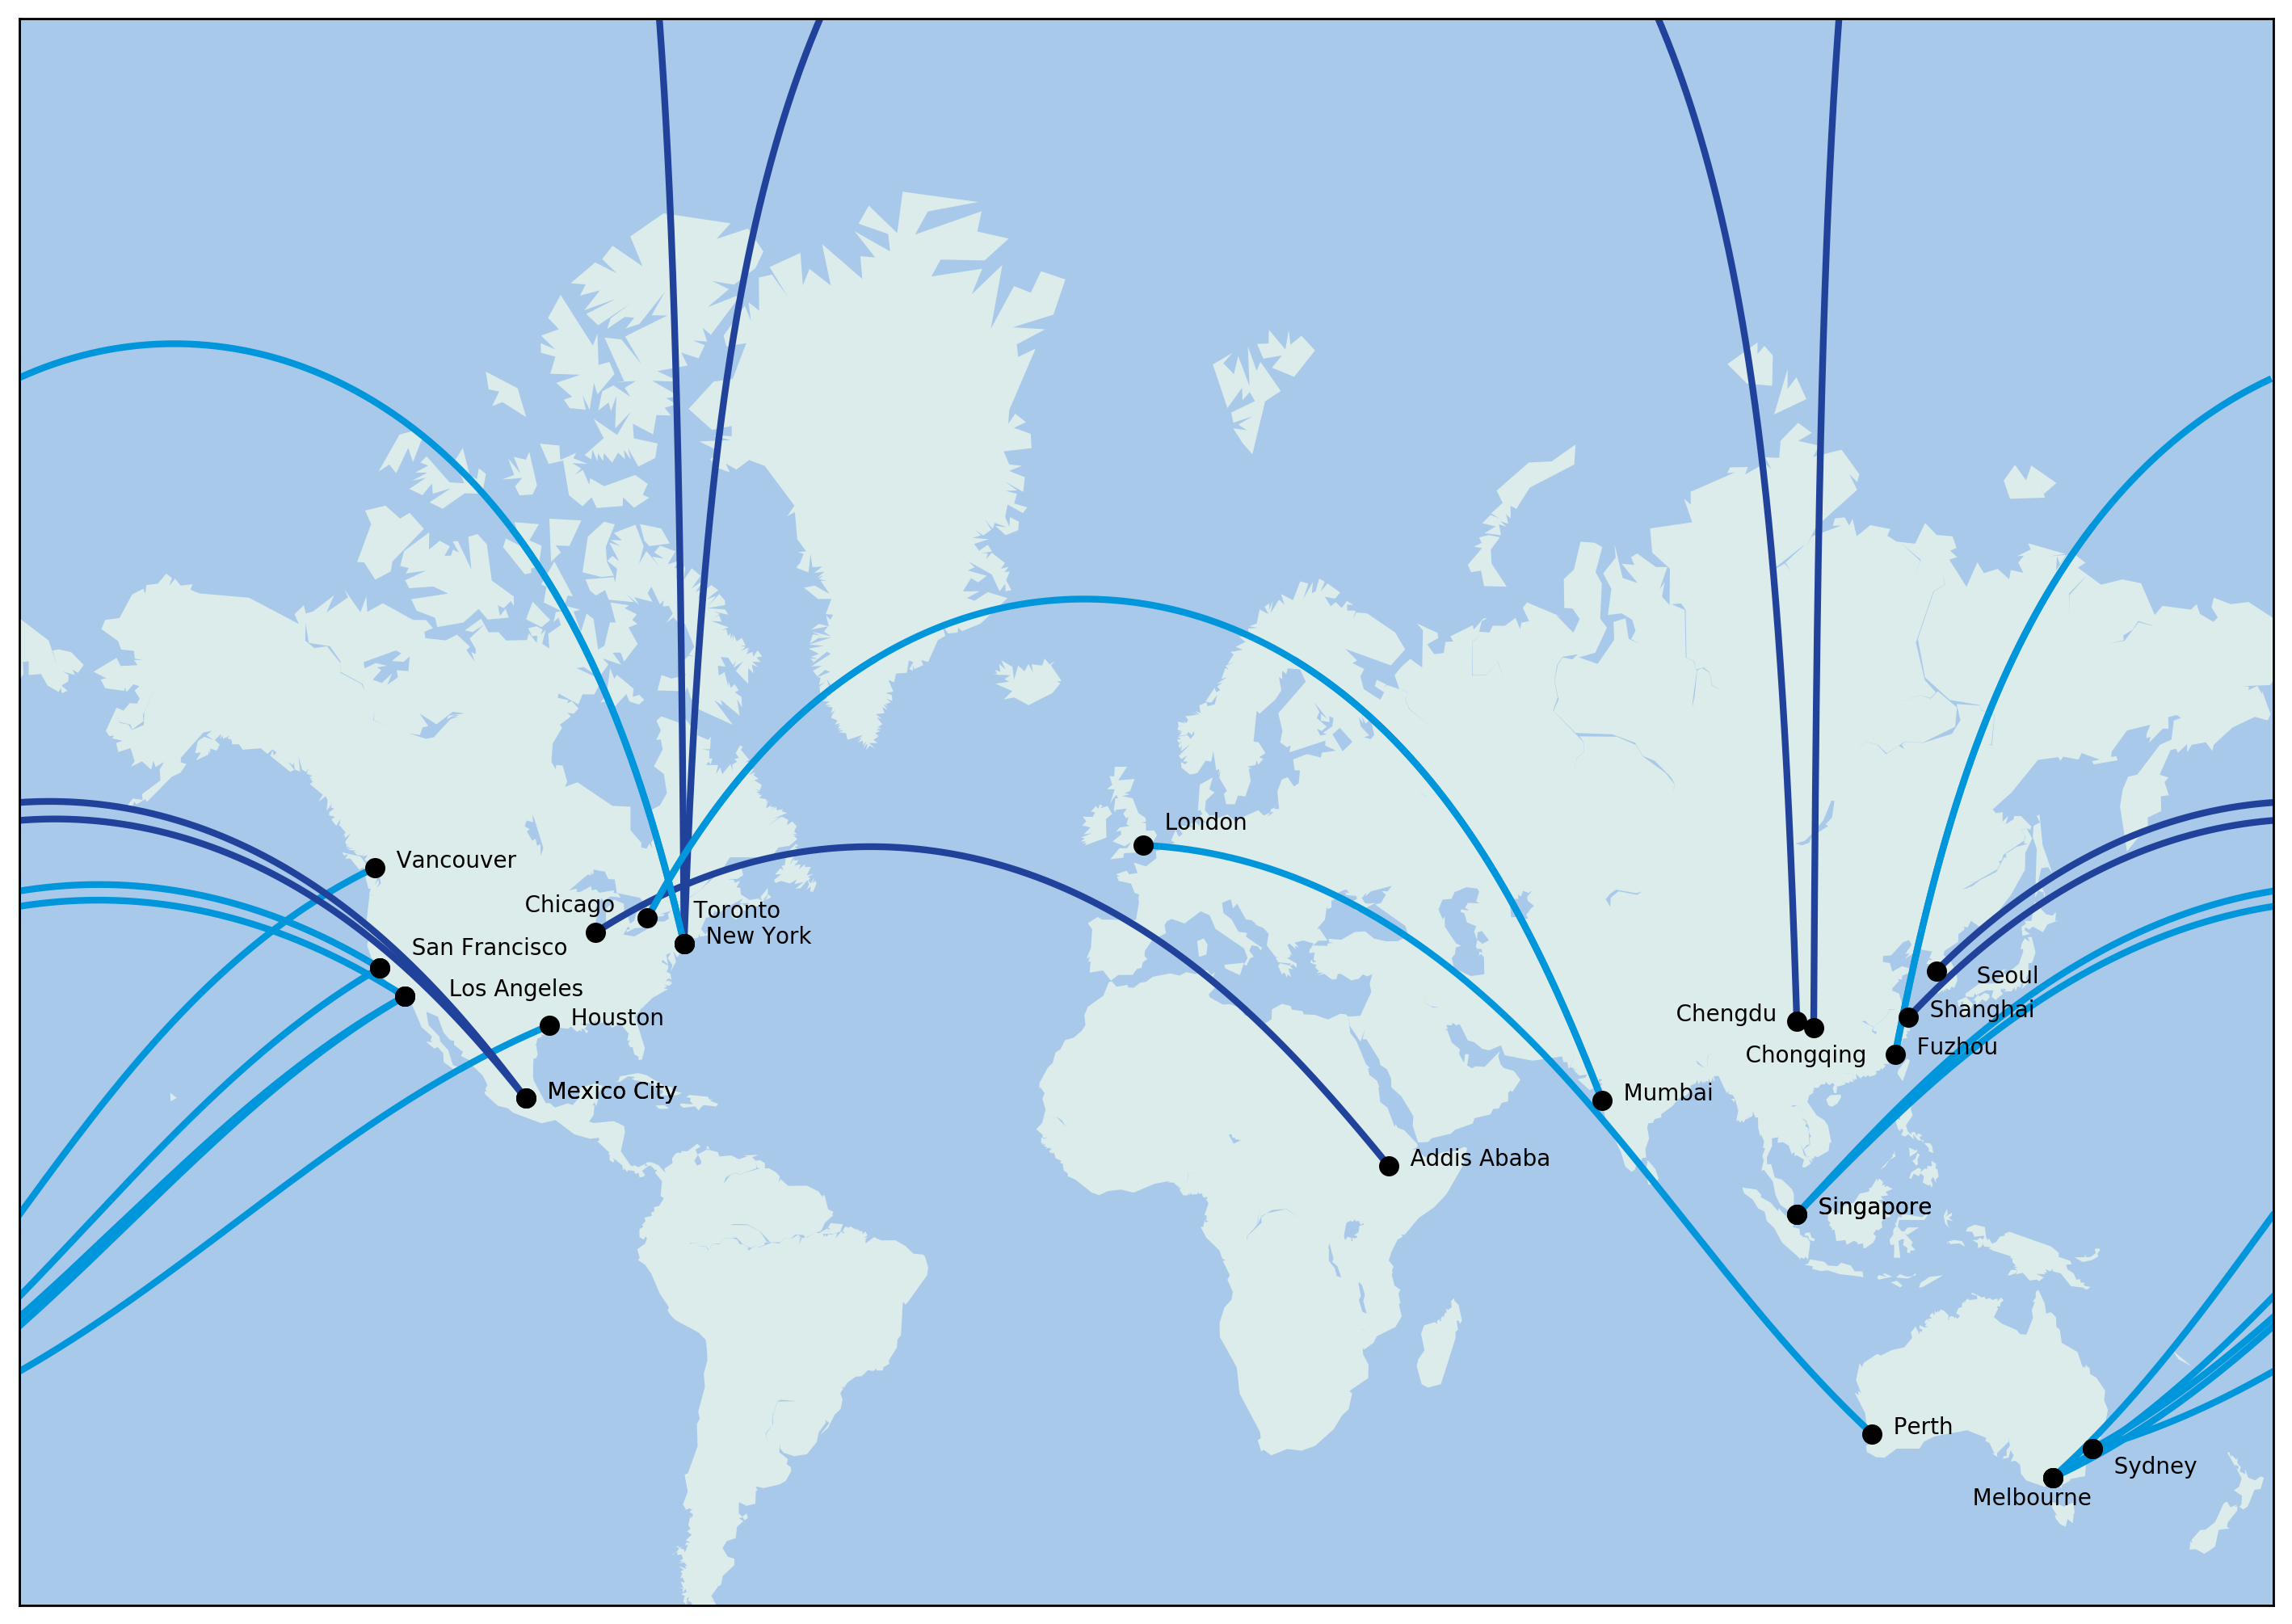

In [192]:
fig = plt.figure(figsize=(18, 18))
ax = plt.gca()
m = Basemap(projection='merc', resolution='c',
            llcrnrlat=-52, urcrnrlat=86,
            llcrnrlon=-180, urcrnrlon=180,
            lat_ts=20)
m.fillcontinents(color=cont_clr,lake_color=wtr_clr)
m.drawmapboundary(fill_color=wtr_clr)

# draw great circles
for i in range(len(x1)):
    if (i != 8) | (i != 9):
        line, = m.drawgreatcircle(
            x1[i],y1[i],x2[i],y2[i],
            del_s=10,c=clr_cnv[minor[i]],
            linewidth=3)
        p= line.get_path()
    
# workaround for broken great circles
line8, = m.drawgreatcircle(
    x1[8],y1[8],x2[8],y2[8],
    del_s=10,c=clr_cnv[minor[8]],
    linewidth=3)
line8.remove()
mx8,my8 = line8.get_data()
m.plot(mx8,my8,color=clr_cnv[minor[8]],linewidth=3)

line9, = m.drawgreatcircle(
    x1[9],y1[9],x2[9],y2[9],
    del_s=10,c=clr_cnv[minor[9]],
    linewidth=3)
line9.remove()
mx9,my9 = line9.get_data()
m.plot(mx9[:592],my9[:592],color=clr_cnv[minor[9]],linewidth=3)
m.plot(mx9[593:],my9[593:],color=clr_cnv[minor[9]],linewidth=3)

# plot departures
plt.plot(dep_x, dep_y, 'ok', markersize=8)
for i in range(len(dep_names)):
    if i not in [3,4,6,7,13,14]:
        plt.text(tdep_x[i], tdep_y[i], dep_names[i], fontsize=10)

# plot arrivals
plt.plot(arr_x, arr_y, 'ok', markersize=8)
for i in range(len(arr_names)):
    if i not in [10,14]:
        plt.text(tarr_x[i], tarr_y[i], arr_names[i], fontsize=10)
        
# save image
plt.savefig('map.png',dpi=200)